In [63]:
from detectron2.model_zoo import get_config
from detectron2.config import LazyConfig
from detectron2.config.instantiate import instantiate

cfg = LazyConfig.load('./configs/yolof.py')

In [64]:
yolof = instantiate(cfg.model)

In [65]:
cfg

{'constants': {'imagenet_rgb256_mean': [123.675, 116.28, 103.53], 'imagenet_rgb256_std': [58.395, 57.12, 57.375], 'imagenet_bgr256_mean': [103.53, 116.28, 123.675], 'imagenet_bgr256_std': [1.0, 1.0, 1.0]}, 'model': {'backbone': {'stem': {'in_channels': 3, 'out_channels': 64, 'norm': 'FrozenBN', '_target_': <class 'detectron2.modeling.backbone.resnet.BasicStem'>}, 'stages': {'depth': 50, 'stride_in_1x1': True, 'norm': 'FrozenBN', '_target_': <function ResNet.make_default_stages at 0x2ae92d940>}, 'out_features': ['res5'], '_target_': <class 'detectron2.modeling.backbone.resnet.ResNet'>}, 'head': None, 'head_in_features': None, 'anchor_generator': {'sizes': [[128, 161.26989438654377, 203.18733465192952]], 'aspect_ratios': [0.5, 1.0, 2.0], 'strides': [32], 'offset': 0.0, '_target_': <class 'detectron2.modeling.anchor_generator.DefaultAnchorGenerator'>}, 'box2box_transform': {'weights': [1.0, 1.0, 1.0, 1.0], '_target_': <class 'detectron2.modeling.box_regression.Box2BoxTransform'>}, 'anchor

In [66]:
!pwd

/Users/giakhang/dev/work/sand_box/hope_to_public_net/khang_net


In [67]:
from modeling.meta_arch.yolof import YOLOFHead
from detectron2.layers.shape_spec import ShapeSpec

In [68]:
yolof_head = YOLOFHead(
    input_shape=[ShapeSpec(channels=512), ShapeSpec(channels=512), ShapeSpec(channels=512), ShapeSpec(channels=512), ShapeSpec(channels=512)],
    num_classes=10, 
    num_anchors=9,
    conv_dims=[256, 256, 256, 256, 256]
)

In [69]:
from detectron2.modeling.anchor_generator import DefaultAnchorGenerator, _create_grid_offsets

In [70]:
sizes = [[x, x * 2 ** (1.0 / 3), x * 2 ** (2.0 / 3)] for x in [32, 64, 128, 256, 512]]
aspect_ratios=[0.5, 1.0, 2.0]
strides=[8, 16, 32, 64, 128]
offset=0.0

In [71]:
anchor_generator = DefaultAnchorGenerator(
    sizes=sizes,
    aspect_ratios=aspect_ratios,
    strides=strides,
    offset=offset
)

In [72]:
import torch

features = []
img_h = img_w = 2048
for stride in strides:
    feature = torch.randn((10, 10, 2048 // stride, 2048 // stride))
    features.append(feature)

In [73]:
anchors = anchor_generator(features)

/Users/giakhang/miniconda3/envs/hope_to_public_net/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025539291/work/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [74]:
num_cell_anchors = 9

for anchor, feature in zip(anchors, features):
    assert len(anchor) == feature.shape[-2] * feature.shape[-1] * num_cell_anchors

In [75]:
import os
from detectron2.data.datasets import register_coco_instances

dataset = 'kitti'
annot_dir = '../kitti/training_coco'
imgs_dir = '../kitti/training_voc/VOC2012/JPEGImages'

for split in ['train', 'val']: 
    annot_path = os.path.join(annot_dir, f'{split}.json')
    d_name = dataset + f'_{split}'
    register_coco_instances(d_name, {}, annot_path, imgs_dir)

In [76]:
from detectron2.model_zoo import get_config
from detectron2.config import LazyConfig
from detectron2.config.instantiate import instantiate

cfg = LazyConfig.load("/Users/giakhang/dev/work/sand_box/hope_to_public_net/detectron2/detectron2/model_zoo/configs/COCO-Detection/retinanet_R_50_FPN_1x.py")
cfg.train.device = 'mps'
cfg.dataloader.evaluator.dataset_name = 'kitti_val'
cfg.dataloader.train.dataset.names = 'kitti_train'
cfg.dataloader.train.mapper.augmentations = []

In [77]:
train_loader = instantiate(cfg.dataloader.train)

In [78]:
first_batch = next(iter(train_loader))

In [79]:
first_batch[0]['image'].shape

torch.Size([3, 375, 1242])

In [80]:
img = first_batch[0]['image'].permute(1, 2, 0)

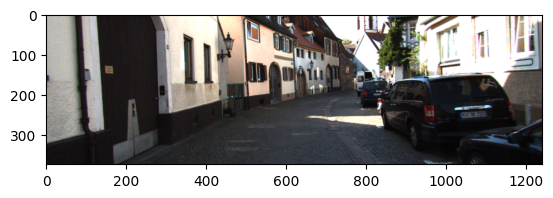

In [81]:
import matplotlib.pyplot as plt

plt.imshow(img.numpy()[:, :, ::-1])

In [82]:
first_batch[0]['instances']

Instances(num_instances=6, image_height=375, image_width=1242, fields=[gt_boxes: Boxes(tensor([[1032.,  188., 1242.,  375.],
        [ 825.,  137., 1197.,  370.],
        [ 786.,  164.,  868.,  235.],
        [ 775.,  139.,  844.,  206.],
        [ 817.,  186.,  873.,  263.],
        [ 700.,  165.,  714.,  194.]])), gt_classes: tensor([7, 7, 7, 6, 2, 1])])

In [83]:
first_batch[0]['instances'][3]

Instances(num_instances=1, image_height=375, image_width=1242, fields=[gt_boxes: Boxes(tensor([[775., 139., 844., 206.]])), gt_classes: tensor([6])])

In [84]:
anchors

[Boxes(tensor([[ -22.6274,  -11.3137,   22.6274,   11.3137],
         [ -16.0000,  -16.0000,   16.0000,   16.0000],
         [ -11.3137,  -22.6274,   11.3137,   22.6274],
         ...,
         [2004.0812, 2022.0406, 2075.9187, 2057.9595],
         [2014.6016, 2014.6016, 2065.3984, 2065.3984],
         [2022.0406, 2004.0812, 2057.9595, 2075.9187]])),
 Boxes(tensor([[ -45.2548,  -22.6274,   45.2548,   22.6274],
         [ -32.0000,  -32.0000,   32.0000,   32.0000],
         [ -22.6274,  -45.2548,   22.6274,   45.2548],
         ...,
         [1960.1625, 1996.0812, 2103.8376, 2067.9187],
         [1981.2031, 1981.2031, 2082.7969, 2082.7969],
         [1996.0812, 1960.1625, 2067.9187, 2103.8376]])),
 Boxes(tensor([[ -90.5097,  -45.2548,   90.5097,   45.2548],
         [ -64.0000,  -64.0000,   64.0000,   64.0000],
         [ -45.2548,  -90.5097,   45.2548,   90.5097],
         ...,
         [1872.3248, 1944.1625, 2159.6750, 2087.8376],
         [1914.4064, 1914.4064, 2117.5938, 2117.5938],

In [85]:
from detectron2.structures import Boxes, pairwise_iou
from detectron2.structures.boxes import pairwise_intersection

In [86]:
len(Boxes.cat(anchors))

785664

In [87]:
num_anchors_all_level = 0

for anchor in anchors:
    num_anchors_all_level += len(anchor)

assert num_anchors_all_level == len(Boxes.cat(anchors))

In [88]:
boxes_1 = first_batch[0]['instances'].gt_boxes
boxes_2 = Boxes.cat(anchors)

In [89]:
def pairwise_intersection(boxes_1, boxes_2):
    boxes_1, boxes_2 = boxes_1.tensor, boxes_2.tensor  # boxes_1.shape = (N, 4); boxes_2.shape = (M, 4)

    inter_x1y1 = torch.max(boxes_1[:, None, :2], boxes_2[:, :2])  # inter_x1y1.shape = (N, M, 4)
    inter_x2y2 = torch.min(boxes_1[:, None, 2:], boxes_2[:, 2:])  # inter_x2y2.shape = (N, M, 4)
    inter_wh = inter_x2y2 - inter_x1y1

    inter_wh.clamp_(min=0)
    intersection_area = inter_wh.prod(dim=-1)  # [N, M]

    return intersection_area

In [90]:
inter_area = pairwise_intersection(boxes_1, boxes_2)

In [91]:
def pairwise_iou(boxes_1, boxes_2):
    area1, area2 = boxes_1.area(), boxes_2.area()
    inter_area = pairwise_intersection(boxes_1, boxes_2)
    iou = torch.where(
        inter_area > 0,
        inter_area / (area1[:, None] + area2 - inter_area),
        torch.zeros(1)
    )

    return iou

In [92]:
iou = pairwise_iou(boxes_1, boxes_2)

In [93]:
iou

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [94]:
thresholds = [-float('inf'), 0.4, 0.4, float('inf')]
labels = [0, -1, 1]

def assign_boxes(iou):
    assert iou.dim() == 2
    assert torch.all(iou >= 0)

    # Find the max iou per predicted box
    match_values, match_gt_idxs = iou.max(dim=0)
    
    # Assign label 
    match_labels = match_gt_idxs.new_full(match_gt_idxs.size(), 1, dtype=torch.int8)
    for (l, low, high) in zip(labels, thresholds[:-1], thresholds[1:]):
        idx = (match_values >= low) & (match_values < high)
        match_labels[idx] = l

    return match_gt_idxs, match_labels

In [95]:
matched_idxs, anchor_labels = assign_boxes(iou)

In [96]:
gt = first_batch[0]['instances']

In [97]:
matched_gt_boxes_i = gt.gt_boxes.tensor[matched_idxs]

gt_labels_i = gt.gt_classes[matched_idxs]

In [98]:
matched_gt_boxes_i.shape

torch.Size([785664, 4])

In [99]:
matched_idxs.shape

torch.Size([785664])

In [100]:
gt_labels_i.shape

torch.Size([785664])

In [101]:
gt.gt_classes

tensor([7, 7, 7, 6, 2, 1])

In [102]:
anchor_labels == 0

tensor([True, True, True,  ..., True, True, True])

In [103]:
gt_labels_i.shape

torch.Size([785664])

In [104]:
first_batch[0]['instances']

Instances(num_instances=6, image_height=375, image_width=1242, fields=[gt_boxes: Boxes(tensor([[1032.,  188., 1242.,  375.],
        [ 825.,  137., 1197.,  370.],
        [ 786.,  164.,  868.,  235.],
        [ 775.,  139.,  844.,  206.],
        [ 817.,  186.,  873.,  263.],
        [ 700.,  165.,  714.,  194.]])), gt_classes: tensor([7, 7, 7, 6, 2, 1])])

In [105]:
from detectron2.layers import cat

strides = [8, 16, 32, 64, 128]
img_h = img_w = 2048
num_anchor_per_loc = 9
batch_size = 16
num_classes = 9

pred_anchor_deltas, pred_logits = [], []

for stride in strides:
    feature_w, feature_h = img_w // stride, img_h // stride
    output_from_level_i = torch.randn(batch_size, 
                                      feature_w * feature_h * num_anchor_per_loc,
                                      4)
    pred_anchor_deltas.append(output_from_level_i)

    torch.rand(batch_size,
                

In [133]:
features = []
img_h = img_w = 2048
for stride in strides:
    feature = torch.randn((10, 10, 2048 // stride, 2048 // stride))
    features.append(feature)

anchors = anchor_generator(features)

gt_instances = []
for img in first_batch:
    gt_instances.append(img['instances'].gt_boxes)

gt_labels = []
num_classes = 9

for i, gt_boxes_per_img in enumerate(gt_instances):
    iou = pairwise_iou(gt_boxes_per_img, Boxes.cat(anchors))
    match_gt_idxs, match_labels = assign_boxes(iou)

    gt_box = first_batch[i]['instances'].gt_boxes.tensor
    gt_cls = first_batch[i]['instances'].gt_classes

    match_gt_boxes = gt_box[match_gt_idxs]
    match_cls = gt_cls[match_gt_idxs]
    match_cls[match_labels == 0] = num_classes
    match_cls[match_labels == -1] = -1
    
    gt_labels.append(match_cls)

In [107]:
pred_anchor_deltas[-1].shape

torch.Size([16, 2304, 4])

In [108]:
gt_labels = torch.stack(gt_labels)

In [114]:
pos_mask = (gt_labels >= 0) & (gt_labels != num_classes)

In [109]:
gt_boxes = torch.stack(gt_boxes)

In [110]:
preds = cat(pred_anchor_deltas, dim=1)

In [111]:
preds.shape

torch.Size([16, 785664, 4])

In [112]:
gt_boxes.shape

torch.Size([16, 785664, 4])

In [115]:
torch.sum(pos_mask)

tensor(5952)

In [116]:
preds[pos_mask].shape

torch.Size([5952, 4])

In [117]:
gt_labels.shape

torch.Size([16, 785664])

In [118]:
first_batch[0]['instances']

Instances(num_instances=6, image_height=375, image_width=1242, fields=[gt_boxes: Boxes(tensor([[1032.,  188., 1242.,  375.],
        [ 825.,  137., 1197.,  370.],
        [ 786.,  164.,  868.,  235.],
        [ 775.,  139.,  844.,  206.],
        [ 817.,  186.,  873.,  263.],
        [ 700.,  165.,  714.,  194.]])), gt_classes: tensor([7, 7, 7, 6, 2, 1])])

In [119]:
import torch
import torch.nn.functional as F

cls_ids = torch.arange(0, 5) % 3

In [120]:
F.one_hot(cls_ids, num_classes=3)

tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0]])

In [170]:
from functools import reduce

num_classes = 9
batch_size = 2
img_size = 512
strides = [8, 16, 32, 64, 128]
feature_map_sizes = [img_size // s for s in strides]
num_anchors_per_loc = 9
num_anchors_all_pyramid = 0
for grid_size in feature_map_sizes:
    num_anchors_all_pyramid += grid_size ** 2 * num_anchors_per_loc
    
shape = (batch_size, num_anchors_all_pyramid)

gt_labels = torch.randint(-1, num_classes + 1, shape)

In [171]:
gt_labels.shape

torch.Size([2, 49104])

In [188]:
gt_labels_target = F.one_hot(gt_labels[gt_labels >= 0], num_classes=num_classes + 1)[:, :-1]

In [189]:
gt_labels_target.shape

torch.Size([89300, 9])

In [190]:
num_classes = 9
batch_size = 2
img_size = 512
strides = [8, 16, 32, 64, 128]
feature_map_sizes = [img_size // s for s in strides]
num_anchors_per_loc = 9
num_anchors_all_pyramid = 0
for grid_size in feature_map_sizes:
    num_anchors_all_pyramid += grid_size ** 2 * num_anchors_per_loc

shape = (batch_size, num_anchors_all_pyramid)
pred_logits = []

for stride in strides:
    grid_s = img_size // stride
    pred_logit_in_level_i = torch.rand((batch_size, grid_s ** 2 * num_anchors_per_loc, num_classes))
    pred_logits.append(pred_logit_in_level_i)

In [191]:
pred_logits = cat(pred_logits, dim=1)

In [192]:
pred_logits[gt_labels >= 0].shape

torch.Size([89300, 9])

In [194]:
len(first_batch)

16